In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.layers import Dropout

In [4]:
data = pd.read_excel('data/shepard_energy_consumption.xlsx')
data.rename(columns={'CUNY City College of New York - 2018-09-01 -> 2023-08-31': 'Timestamp'}, inplace=True)
data.drop(data.index[0], inplace=True)
data.rename(columns={'12785711': 'Meter1'}, inplace=True)
data.rename(columns={'12785712': 'Meter2'}, inplace=True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)
data.head(10)

,Meter1,Meter2
Timestamp,,
2018-09-01 01:00:00,124,217.5
2018-09-01 02:00:00,124,218
2018-09-01 03:00:00,126,216.5
2018-09-01 04:00:00,124,216
2018-09-01 05:00:00,122.5,219
2018-09-01 06:00:00,123,218
2018-09-01 07:00:00,120.5,227
2018-09-01 08:00:00,121.5,231.5
2018-09-01 09:00:00,122.5,231.5


In [28]:


# Apply MinMaxScaler meter 1
scaler_meter1 = MinMaxScaler(feature_range=(0, 1))
scaled_meter1= scaler_meter1.fit_transform(data[['Meter1']])

In [29]:
# scale meter 2 seperateley 
scaler_meter2 = MinMaxScaler(feature_range=(0, 1))
scaled_meter2 = scaler_meter2.fit_transform(data[['Meter2']])


In [30]:
# Combining the scaled data
scaled_data = np.hstack([scaled_meter1, scaled_meter2])

In [31]:
print(scaled_data)

[[0.55555556 0.60898876]
 [0.55555556 0.61123596]
 [0.56790123 0.60449438]
 ...
 [0.36728395 0.48988764]
 [0.36728395 0.4494382 ]
 [0.36419753 0.41123596]]


In [26]:
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [32]:
look_back = 24
X, y = [], []

for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i-look_back:i])  # Previous 24 hours
    y.append(scaled_data[i])  # The next hour's readings for both meters

X, y = np.array(X), np.array(y)





In [38]:
print(X.shape, y.shape)

(43800, 24, 2) (43800, 2)


In [35]:
# Splitting data for Meter 1 and Meter 2 predictions
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X, y[:, 0], test_size=0.2, random_state=42)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X, y[:, 1], test_size=0.2, random_state=42)

In [36]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [37]:

# Building the models
model_meter_1 = build_model((X_train_1.shape[1], X_train_1.shape[2]))
model_meter_2 = build_model((X_train_2.shape[1], X_train_2.shape[2]))


In [89]:
print((X_train_1.shape[1], X_train_1.shape[2]))
print((X_train_2.shape[1], X_train_2.shape[2]))

(24, 2)
(24, 2)


In [66]:
model_meter_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 50)            10600     
                                                                 
 dropout_4 (Dropout)         (None, 24, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30851 (120.51 KB)
Trainable params: 30851 (120.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:

# Training the models
history_meter_1 = model_meter_1.fit(X_train_1, y_train_1, epochs=10, batch_size=32, validation_data=(X_val_1, y_val_1), verbose=1)
history_meter_2 = model_meter_2.fit(X_train_2, y_train_2, epochs=10, batch_size=32, validation_data=(X_val_2, y_val_2), verbose=1)

Epoch 1/10
1095/1095 [==============================] - 33s 25ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 2/10
1095/1095 [==============================] - 40s 36ms/step - loss: 0.0018 - val_loss: 6.4979e-04
Epoch 3/10
1095/1095 [==============================] - 39s 35ms/step - loss: 0.0012 - val_loss: 6.0828e-04
Epoch 4/10
1095/1095 [==============================] - 31s 28ms/step - loss: 8.9675e-04 - val_loss: 4.6944e-04
Epoch 5/10
1095/1095 [==============================] - 31s 29ms/step - loss: 7.4944e-04 - val_loss: 4.3028e-04
Epoch 6/10
1095/1095 [==============================] - 37s 34ms/step - loss: 6.7873e-04 - val_loss: 5.0445e-04
Epoch 7/10
1095/1095 [==============================] - 34s 31ms/step - loss: 6.6671e-04 - val_loss: 4.8926e-04
Epoch 8/10
1095/1095 [==============================] - 35s 32ms/step - loss: 6.4113e-04 - val_loss: 4.4245e-04
Epoch 9/10
1095/1095 [==============================] - 33s 30ms/step - loss: 6.3094e-04 - val_loss: 4.4677e-04
Epoch 10

In [94]:
model_meter_1.shape()

AttributeError: 'Sequential' object has no attribute 'shape'

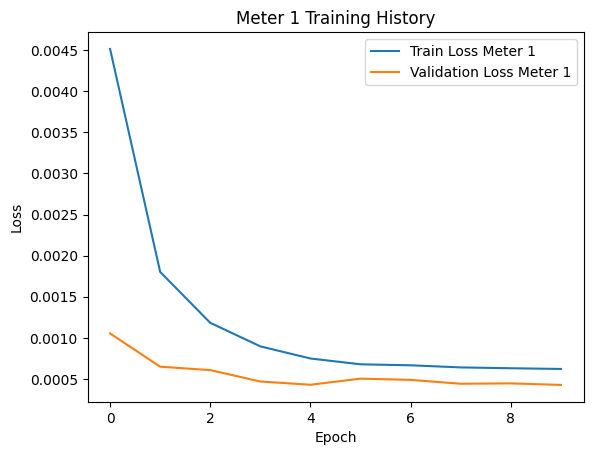

In [40]:
plt.plot(history_meter_1.history['loss'], label='Train Loss Meter 1')
plt.plot(history_meter_1.history['val_loss'], label='Validation Loss Meter 1')
plt.title('Meter 1 Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Repeat for Meter 2


In [41]:

# Making predictions
predictions_meter_1 = model_meter_1.predict(X_val_1)
predictions_meter_2 = model_meter_2.predict(X_val_2)


274/274 [==============================] - 5s 11ms/step


In [46]:
print(predictions_meter_1)

[[112.89517 ]
 [ 98.20486 ]
 [ 95.48255 ]
 ...
 [ 94.756775]
 [ 95.20145 ]
 [112.9483  ]]


In [42]:
# Assuming you used separate scalers for each meter
predictions_meter_1 = scaler_meter1.inverse_transform(predictions_meter_1)
predictions_meter_2 = scaler_meter2.inverse_transform(predictions_meter_2)


In [49]:

mse_meter_1 = mean_squared_error(y_val_1, predictions_meter_1)
mse_meter_2 = mean_squared_error(y_val_2, predictions_meter_2)

print("Mean Squared Error for Meter 1: ", mse_meter_1)
print("Mean Squared Error for Meter 2: ", mse_meter_2)

Mean Squared Error for Meter 1:  11134.60490227966
Mean Squared Error for Meter 2:  34890.38205816412


In [56]:
y_val_1_2d = y_val_1.reshape(-1, 1)

# Apply inverse transformation
val_meter_1 = scaler_meter1.inverse_transform(y_val_1_2d)

In [59]:
y_val_2_2d = y_val_2.reshape(-1, 1)

# Apply inverse transformation
val_meter_2 = scaler_meter2.inverse_transform(y_val_2_2d)

In [61]:
mse_meter_1 = mean_squared_error(val_meter_1, predictions_meter_1)
mse_meter_2 = mean_squared_error(val_meter_2, predictions_meter_2)

print("Mean Squared Error for Meter 1: ", mse_meter_1)
print("Mean Squared Error for Meter 2: ", mse_meter_2)

Mean Squared Error for Meter 1:  11.234812052525477
Mean Squared Error for Meter 2:  32.966153307319125


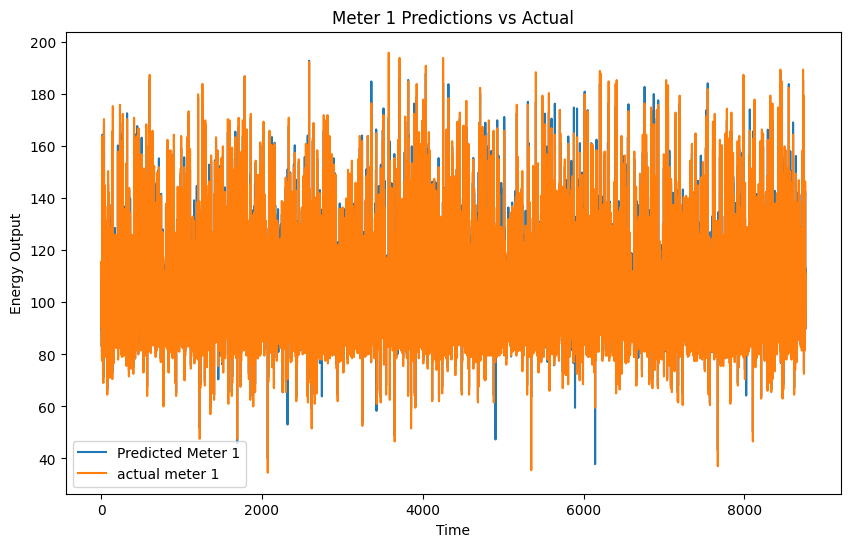

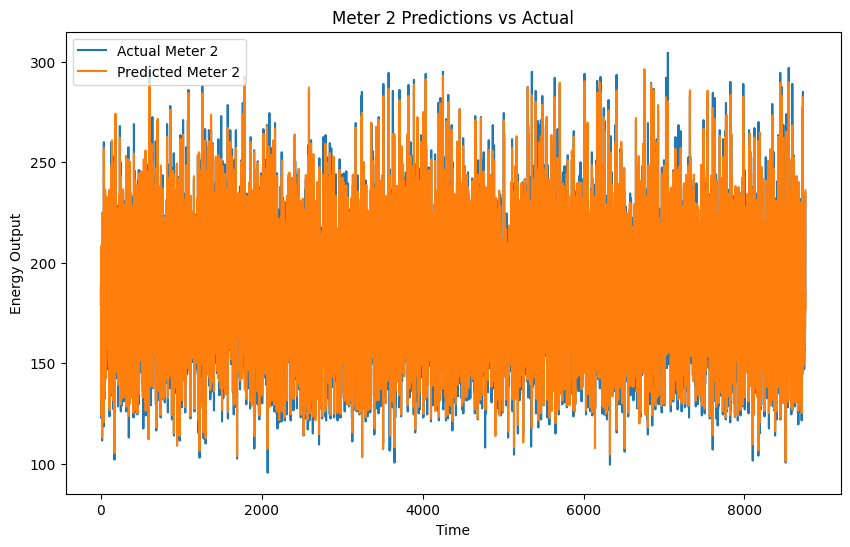

In [60]:
import matplotlib.pyplot as plt

# Plot for Meter 1
plt.figure(figsize=(10, 6))
plt.plot(predictions_meter_1, label='Predicted Meter 1')
plt.plot(val_meter_1, label = "actual meter 1")
plt.title('Meter 1 Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Energy Output')
plt.legend()
plt.show()

# Plot for Meter 2
plt.figure(figsize=(10, 6))
plt.plot(val_meter_2, label='Actual Meter 2')
plt.plot(predictions_meter_2, label='Predicted Meter 2')
plt.title('Meter 2 Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Energy Output')
plt.legend()
plt.show()


In [96]:
time_steps = 24

# Select the last 'time_steps' observations from the dataset for both meters
recent_data_meter1 = data['Meter1'][-time_steps:].values.reshape(-1,1)
recent_data_meter2 = data['Meter2'][-time_steps:].values.reshape(-1,1)

# data for each meter separately
recent_data_scaled_meter1 = scaler_meter1.transform(recent_data_meter1)
recent_data_scaled_meter2 = scaler_meter2.transform(recent_data_meter2)

recent_data_scaled = np.hstack([recent_data_scaled_meter1, recent_data_scaled_meter2])



c:\Users\jubya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\jubya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [118]:
sequence = np.reshape(recent_data_scaled, ( 24, 2))


In [117]:
print(sequence[:, :, 0].shape)
print(sequence[:, :, 1])
sequence.shape

(1, 24)
[[0.39325843 0.39550562 0.4        0.4        0.38426966 0.38426966
  0.41123596 0.45617978 0.48314607 0.54382022 0.6494382  0.69438202
  0.68988764 0.69438202 0.71235955 0.69662921 0.6741573  0.62247191
  0.57752809 0.5505618  0.54382022 0.48988764 0.4494382  0.41123596]]


(1, 24, 2)

In [119]:
predictions_future = []

for i in range(168):  # Predict for 7 days, 24 hours each
    # Predict the next hour
    next_hour_scaled = model_meter_1.predict(sequence)
    next_hour = np.column_stack([scaler_meter1.inverse_transform(next_hour_scaled[:, 0].reshape(-1, 1)),
                                 scaler_meter2.inverse_transform(next_hour_scaled[:, 1].reshape(-1, 1))])
    
    # Append the unscaled prediction
    predictions_future.append(next_hour[0, :])
    
    # Update the sequence with the new prediction
    sequence = np.roll(sequence, -1, axis=1)
    sequence[0, -1, :] = next_hour_scaled[0, :]


TypeError: in user code:

    File "c:\Users\jubya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\jubya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jubya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\jubya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\jubya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\jubya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\lstm.py", line 616, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm_4' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm_4' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [102]:
sequence[0,1,1]

0.39550561797752815